In [1]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from itertools import combinations
import random
import warnings
warnings.filterwarnings("ignore")

# library for xG, scraping data from understat.com
from understatapi import UnderstatClient
from tqdm import tqdm

Simulating a Premier Leaugue season based on the results of the previous season.

To validate the models accuracy we compare it to the actual outcome of each game, and the odds of Bet365.

In [2]:
understat = UnderstatClient()

# 2019
df_us_2019 = pd.json_normalize(understat.league(league="EPL").get_match_data(season="2019"))

df_us_2019.rename(columns = {'h.title': 'home_team', 'a.title': 'away_team', 'goals.h': 'home_goals', 'goals.a': 'away_goals', 'xG.h': 'xG_home', 'xG.a': 'xG_away'}, inplace=True)
df_us_2019[['home_goals','away_goals','xG_home', 'xG_away']] = df_us_2019[['home_goals','away_goals','xG_home', 'xG_away']].apply(pd.to_numeric)

# 2020
df_us_2020 = pd.json_normalize(understat.league(league="EPL").get_match_data(season="2020"))

df_us_2020.rename(columns = {'h.title': 'home_team', 'a.title': 'away_team', 'goals.h': 'home_goals', 'goals.a': 'away_goals', 'xG.h': 'xG_home', 'xG.a': 'xG_away'}, inplace=True)
df_us_2020[['home_goals','away_goals','xG_home', 'xG_away']] = df_us_2020[['home_goals','away_goals','xG_home', 'xG_away']].apply(pd.to_numeric)

# 2021
df_us_2021 = pd.json_normalize(understat.league(league="EPL").get_match_data(season="2021"))

df_us_2021.rename(columns = {'h.title': 'home_team', 'a.title': 'away_team', 'goals.h': 'home_goals', 'goals.a': 'away_goals', 'xG.h': 'xG_home', 'xG.a': 'xG_away'}, inplace=True)
df_us_2021[['home_goals','away_goals','xG_home', 'xG_away']] = df_us_2021[['home_goals','away_goals','xG_home', 'xG_away']].apply(pd.to_numeric)



In [3]:
def getTrueResults(home_team, away_team, year):
    if year == 2020:
        df = df_us_2020
    elif year == 2021:
        df = df_us_2021
    
    home_goals = df.loc[(df.home_team == home_team) & (df.away_team == away_team)].home_goals.values[0]
    away_goals = df.loc[(df.home_team == home_team) & (df.away_team == away_team)].away_goals.values[0]
    
    if home_goals > away_goals:
        result = '1'
    elif home_goals == away_goals:
        result = 'X'
    else: # home_goals < away_goals:
        result = '2'
    return result

In [6]:
epl = pd.read_csv("https://www.football-data.co.uk/mmz4281/2021/E0.csv")
epl = epl[['HomeTeam','AwayTeam','FTHG','FTAG', 'B365H', 'B365D', 'B365A']]
epl = epl.rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
epl['B365H_prob'] = 1 / (epl['B365H'])
epl['B365D_prob'] = 1 / (epl['B365D'])
epl['B365A_prob'] = 1 / (epl['B365A'])
epl['sum'] = epl['B365H_prob'] + epl['B365D_prob'] + epl['B365A_prob']
epl['B365H_prob'] = epl['B365H_prob'] / epl['sum']
epl['B365D_prob'] = epl['B365D_prob'] / epl['sum']
epl['B365A_prob'] = epl['B365A_prob'] / epl['sum']
epl['sum'] = epl['B365H_prob'] + epl['B365D_prob'] + epl['B365A_prob']

# Align bet365 naming with understat naming.
epl.replace({'Man City': 'Manchester City'}, regex=True, inplace=True)
epl.replace({'Man United': 'Manchester United'}, regex=True, inplace=True)
epl.replace({'Newcastle': 'Newcastle United'}, regex=True, inplace=True)
epl.replace({'West Brom': 'West Bromwich Albion'}, regex=True, inplace=True)
epl.replace({'Wolves': 'Wolverhampton Wanderers'}, regex=True, inplace=True)


def simulateMatchBet365(home_team, away_team, year):
    if year != 2020:
        return 'Undefined for other than 2020'
    
    home_prob = epl.loc[(epl.HomeTeam == home_team) & (epl.AwayTeam == away_team)].B365H_prob.values[0]
    x_prob = epl.loc[(epl.HomeTeam == home_team) & (epl.AwayTeam == away_team)].B365D_prob.values[0]
    away_prob = epl.loc[(epl.HomeTeam == home_team) & (epl.AwayTeam == away_team)].B365A_prob.values[0]
    
    val = np.random.uniform(0,home_prob+x_prob+away_prob,1) # sum if not normalised probabilities
    if val <= home_prob:
        result = '1'
    elif val > home_prob and val <= home_prob + x_prob:
        result = 'X'
    else: # val > home_prob + x_prob
        result = '2'
    return result

## Base Model

In [14]:
df_base = df_us_2019.copy()

# Replace relegated teams with promoted teams.
df_base.home_team.replace('Bournemouth','Leeds', inplace=True)
df_base.home_team.replace('Watford','West Bromwich Albion', inplace=True)
df_base.home_team.replace('Norwich','Fulham', inplace=True)
df_base.away_team.replace('Bournemouth','Leeds', inplace=True)
df_base.away_team.replace('Watford','West Bromwich Albion', inplace=True)
df_base.away_team.replace('Norwich','Fulham', inplace=True)

In [15]:
# Create a GLM with Poission fit.
goal_model_data_baseline = pd.concat([
    df_base[['home_team','away_team','home_goals']].assign(home=True).rename(columns={'home_team':'team', 'away_team':'opponent','home_goals':'goals'}),
    df_base[['away_team','home_team','away_goals']].assign(home=False).rename(columns={'away_goals':'team', 'home_goals':'opponent','away_goals':'goals'})
])

base_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data_baseline,
                        family=sm.families.Poisson()).fit()
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  380
Model:                            GLM   Df Residuals:                      341
Model Family:                 Poisson   Df Model:                           38
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -538.33
Date:                Sat, 27 Jan 2024   Deviance:                       343.26
Time:                        10:59:49   Pearson chi2:                     288.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2341
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                               0.2320      0.134      1.736      0.082      -0.030       0.494
home[T.True]                            0.2320      0.134      1.736      0.082      -0.030       0.494
team[T.Aston Villa]                    -0.4699      0.271     -1.734      0.083      -1.001       0.061
team[T.Brighton]                       -0.5837      0.279     -2.091      0.037      -1.131      -0.036
team[T.Burnley]                        -0.4010      0.264     -1.520      0.129      -0.918       0.116
team[T.Chelsea]                        -0.1569      0.248     -0.634      0.526      -0.642       0.328
team[T.Crystal Palace]                 -0.8664      0.308     -2.817      0.005      -1.469      -0.264
team[T.Everton]                        -0.3864      0.264     -1.464      0.143      -0.904       0.131
team[T.Fulham]                         -0.6151      0.284     -2.166      0.030      -1.172      -0.059
team[T.Leeds]                          -0.4736      0.271     -1.748      0.080      -1.005       0.057
team[T.Leicester]                      -0.0283      0.238     -0.119      0.905      -0.494       0.438
team[T.Liverpool]                       0.3558      0.217      1.639      0.101      -0.070       0.781
team[T.Manchester City]                 0.4575      0.213      2.145      0.032       0.039       0.875
team[T.Manchester United]               0.0964      0.230      0.419      0.675      -0.354       0.547
team[T.Newcastle United]               -0.5655      0.279     -2.025      0.043      -1.113      -0.018
team[T.Sheffield United]               -0.4064      0.264     -1.540      0.123      -0.924       0.111
team[T.Southampton]                    -0.5384      0.275     -1.959      0.050      -1.077       0.000
team[T.Tottenham]                       0.0111      0.236      0.047      0.962      -0.452       0.474
team[T.West Bromwich Albion]           -0.4699      0.271     -1.734      0.083      -1.001       0.061
team[T.West Ham]                       -0.1736      0.248     -0.701      0.483      -0.659       0.312
team[T.Wolverhampton Wanderers]        -0.2938      0.255     -1.153      0.249      -0.793       0.206
opponent[T.Aston Villa]                 0.4083      0.262      1.556      0.120      -0.106       0.923
opponent[T.Brighton]                    0.0889      0.281      0.317      0.752      -0.462       0.639
opponent[T.Burnley]                     0.0961      0.281      0.342      0.732      -0.454       0.647
opponent[T.Chelsea]                     0.4500      0.261      1.723      0.085      -0.062       0.962
opponent[T.Crystal Palace]              0.1855      0.274      0.676      0.499      -0.352       0.723
opponent[T.Everton]                     0.3563      0.265      1.34

In [16]:
def simulateMatchBase(model, home_team, away_team):
    home_score_rate = model.predict(pd.DataFrame(data={'team': home_team, 'opponent': away_team, 'home': True},index=[1]))
    away_score_rate = model.predict(pd.DataFrame(data={'team': away_team, 'opponent': home_team, 'home': False},index=[1]))
    
    # Simulate results
    home_goals = np.random.poisson(home_score_rate)[0]
    away_goals = np.random.poisson(away_score_rate)[0]
    
    return home_team, home_goals, away_team, away_goals

In [18]:
def simulateSeasonBase(model, year, return_table=False, return_pred_results=False):

    teams = df_base.home_team.unique()
          
    # Store outcome of results in a dict to create the table later on
    standings = dict()

    results = {
        'W': 0,
        'D': 0,
        'L': 0,
        'GF': 0,
        'GA': 0
    }
    
    for team in teams:
        standings[team] = results

    standings = pd.DataFrame.from_dict(standings, orient='index')
    match_predictions = [0,0,0,0] # model_right, model_wrong, bet365_right, bet365_wrong

    for i in teams:
        for j in teams:
            if i != j:
                home_team, home_goals, away_team, away_goals = simulateMatchBase(model, i, j)
                result_true = getTrueResults(i, j, year)
                result_sim = ''
                    
                # Assign results to standings
                if home_goals > away_goals:
                    standings.at[home_team, 'W'] += 1
                    standings.at[away_team, 'L'] += 1
                    result_sim = '1'
                elif home_goals < away_goals:
                    standings.at[home_team, 'L'] += 1
                    standings.at[away_team, 'W'] += 1
                    result_sim = '2'
                else:
                    standings.at[home_team, 'D'] += 1
                    standings.at[away_team, 'D'] += 1
                    result_sim = 'X'

                standings.at[home_team, 'GF'] += home_goals
                standings.at[home_team, 'GA'] += away_goals

                standings.at[away_team, 'GF'] += away_goals
                standings.at[away_team, 'GA'] += home_goals
                
                
                match_predictions[0] += 1 * (result_sim == result_true)
                match_predictions[1] += 1 * (result_sim != result_true)


    standings['M'] = standings.W + standings.D + standings.L # Matches
    standings['GD'] = standings.GF - standings.GA  # Goal difference
    standings['P'] = 3 * standings.W + 1 * standings.D  # Points

    table = standings.sort_values(by=['P', 'GD'], ascending=False).rename_axis('Team').reset_index()
    table.index = np.arange(1, len(table) + 1)
    
    if return_table:
        return table
    else:
        if not return_pred_results:
            return table.loc[table.Team == 'Leeds'].index[0]  # return Leeds placement in the league.
        else:
            return table.loc[table.Team == 'Leeds'].index[0], match_predictions  # return placement and prediction results

In [21]:
# Simulate the 2020/2021 season
simulateSeasonBase(base_model, 2020, return_table=True)

,Team,W,D,L,GF,GA,M,GD,P
1,Liverpool,29,4,5,96,24,38,72,91
2,Manchester City,27,8,3,96,42,38,54,89
3,Manchester United,23,8,7,70,29,38,41,77
4,Tottenham,20,9,9,77,52,38,25,69
5,Wolverhampton Wanderers,21,6,11,53,38,38,15,69
6,Arsenal,19,11,8,72,46,38,26,68
7,Leicester,19,11,8,73,51,38,22,68
8,Chelsea,16,5,17,64,61,38,3,53
9,Burnley,13,13,12,44,45,38,-1,52
10,Sheffield United,14,7,17,44,48,38,-4,49


## Add xG data

In [9]:
# Highest avg xG at home
home_xg_2019 = df_us_2019.groupby(['home_team']).xG_home.mean().sort_values(ascending=False).reset_index().rename(columns={'home_team': 'team'})

# Highest avg xG awayc
away_xg_2019 = df_us_2019.groupby(['away_team']).xG_away.mean().sort_values(ascending=False).reset_index().rename(columns={'away_team': 'team'})

# Lowest avg xGC at home
home_xgc_2019 = df_us_2019.groupby(['home_team']).xG_away.mean().sort_values().reset_index().rename(columns={'home_team': 'team','xG_away': 'xGC_home'})

# Lowest avg xGC at home
away_xgc_2019 = df_us_2019.groupby(['away_team']).xG_home.mean().sort_values().reset_index().rename(columns={'away_team': 'team','xG_home': 'xGC_away'})

df_xg_2019 = home_xg_2019.merge(away_xg_2019).merge(home_xgc_2019).merge(away_xgc_2019)

In [10]:
# Highest avg xG at home
home_xg_2020 = df_us_2020.groupby(['home_team']).xG_home.mean().sort_values(ascending=False).reset_index().rename(columns={'home_team': 'team'})

# Highest avg xG away
away_xg_2020 = df_us_2020.groupby(['away_team']).xG_away.mean().sort_values(ascending=False).reset_index().rename(columns={'away_team': 'team'})

# Lowest avg xGC at home
home_xgc_2020 = df_us_2020.groupby(['home_team']).xG_away.mean().sort_values().reset_index().rename(columns={'home_team': 'team','xG_away': 'xGC_home'})

# Lowest avg xGC at home
away_xgc_2020 = df_us_2020.groupby(['away_team']).xG_home.mean().sort_values().reset_index().rename(columns={'away_team': 'team','xG_home': 'xGC_away'})

df_xg_2020 = home_xg_2020.merge(away_xg_2020).merge(home_xgc_2020).merge(away_xgc_2020)

In [29]:
def get_xG(team, at_home, year, scenario=None):
    if scenario not in [None, "bamford", "setpiece"]:
        print("Incorrect scenario")
    if year == 2020:
        df = df_xg_2019
    elif year == 2021:
        df = df_xg_2020    
    
    if at_home:
        if team == "Leeds" and scenario == "bamford":
                return df.loc[df.team == team].xG_home.values[0] + 0.084  #3.2 goals less per season

        return df.loc[df.team == team].xG_home.values[0]
    else:
        if team == "Leeds" and scenario == "bamford":
                return df.loc[df.team == team].xG_away.values[0] - 0.084 

        return df.loc[df.team == team].xG_away.values[0]

    
def get_xGC(team, at_home, year, scenario=None):
    if year == 2020:
        df = df_xg_2019
    elif year == 2021:
        df = df_xg_2020    
    
    if at_home:
        if team == "Leeds" and scenario == "setpiece":
            return df.loc[df.team == team].xGC_home.values[0]-0.21 #Reduce to League Average
        return df.loc[df.team == team].xGC_home.values[0]
    else:
        if team == "Leeds" and scenario == "setpiece":
            return df.loc[df.team == team].xGC_away.values[0]-0.21
        return df.loc[df.team == team].xGC_away.values[0]

## Add Market Value data from Transfermarkt

In [12]:
transfermarkt = pd.read_csv('transfermarkt.csv')

def format_value(mv_str):
    mv_str = mv_str.replace('€','')
    
    if 'bn' in mv_str:
        return float(mv_str.replace('bn','')) * 1000
    else:
        return float(mv_str.replace('m',''))

transfermarkt['market_value'] = transfermarkt.market_value.apply(lambda x: format_value(x))

In [13]:
# Add normalized market values
transfermarkt['market_value_log'] = np.log(transfermarkt.market_value)
transfermarkt['market_value_sqrt'] = np.sqrt(transfermarkt.market_value)

In [14]:
transfermarkt_2020 = transfermarkt.loc[transfermarkt.year == 2020, ['team','market_value', 'market_value_log','market_value_sqrt']]
transfermarkt_2021 = transfermarkt.loc[transfermarkt.year == 2021, ['team','market_value', 'market_value_log','market_value_sqrt']]

In [15]:
def get_market_value(team, year, normalization=None):
    if year == 2020:
        team_values = transfermarkt_2020.loc[transfermarkt_2020.team == team]
    elif year == 2021:
        team_values = transfermarkt_2021.loc[transfermarkt_2021.team == team]
    
    if normalization == 'log':
        return team_values.market_value_log.values[0]
    elif normalization == 'sqrt':
        return team_values.market_value_sqrt.values[0]
    else:
        return team_values.market_value.values[0]

## Compare Model Performance
Based on simulations on 2020/2021 season based on data from 2019/2020.

### Add values for promoted teams
Sampled from values of previously promoted teams during their first season.

In [19]:
# [xG_home, xGC_home, xG_away, xGC_away]
df_promoted = {2020: {"Leeds United": [33.09,24.55,26.17,38.47], "West Bromwich Albion": [18.20,38.69,16.78,35.35], "Fulham": [19.08,28.22,21.98,29.42]},
            2019: {"Norwich City": [18.38,35.28,18.85,36.33], "Sheffield United": [27.84,21.20,17.97,30.84], "Aston Villa": [23.81,33.69,21.28,37.90]},
            2018: {"Wolverhampton Wanderers": [31.78,18.73,21.28,23.96],"Cardiff City": [24.55,26.91,17.22,39.59], "Fulham":[24.75,30.31,17.87,43.28]}}

promoted_xg = {}
for season in df_promoted.keys():
    prom_teams = 0
    for team in df_promoted[season]:
        promoted_xg[f"Promoted_{prom_teams}_{season}_{team}"] = np.array(df_promoted[season][team]) / 19 ## 19 games home/away
        prom_teams +=1

In [20]:
promoted_teams = ["Fulham","West Bromwich Albion","Leeds"]

for team in promoted_teams:
    sample = np.random.choice(list(promoted_xg.keys()),size=1, replace=False)[0]
    # Assign a sampled xG & xGC to the promoted teams. If promoted team not in df, create a new row. If it is, overwrite current values.
    if team in df_xg_2019.team.values:
        df_xg_2019.loc[df_xg_2019.team == team, ['xG_home','xG_away','xGC_home','xGC_away']] = promoted_xg[sample]
    else:
        df_xg_2019.loc[len(df_xg_2019.index)] = [team] + [x for x in promoted_xg[sample]]

### Prepare model data

In [21]:
df_model = df_us_2020[['home_team','away_team','home_goals','away_goals']]
df_model['xG_home'] = df_model.apply(lambda x: get_xG(x.home_team, True, 2020), axis=1)
df_model['xGC_home'] = df_model.apply(lambda x: get_xGC(x.home_team, True, 2020), axis=1)
df_model['xG_away'] = df_model.apply(lambda x: get_xG(x.away_team, False, 2020), axis=1)
df_model['xGC_away'] = df_model.apply(lambda x: get_xGC(x.away_team, False, 2020), axis=1)
df_model['market_value_home'] = df_model.apply(lambda x: get_market_value(x.home_team, 2020), axis=1)
df_model['market_value_away'] = df_model.apply(lambda x: get_market_value(x.away_team, 2020), axis=1)

# Add normalized market values
df_model['market_value_home_log'] = df_model.apply(lambda x: get_market_value(x.home_team, 2020, normalization='log'), axis=1)
df_model['market_value_away_log'] = df_model.apply(lambda x: get_market_value(x.away_team, 2020, normalization='log'), axis=1)
df_model['market_value_home_sqrt'] = df_model.apply(lambda x: get_market_value(x.home_team, 2020, normalization='sqrt'), axis=1)
df_model['market_value_away_sqrt'] = df_model.apply(lambda x: get_market_value(x.away_team, 2020, normalization='sqrt'), axis=1)

In [7]:
def simulateMatchXG(model, home_team, away_team, year, model_type, scenario=None):
    
    if model_type == 'xG':
        home_score_rate = model.predict(pd.DataFrame(data={'team_xG': get_xG(home_team, True, year, scenario=scenario), 'opponent_xGC': get_xGC(away_team, False, year, scenario=scenario)},index=[1]))
        away_score_rate = model.predict(pd.DataFrame(data={'team_xG': get_xG(away_team, False, year, scenario=scenario), 'opponent_xGC': get_xGC(home_team, True, year, scenario=scenario)},index=[1]))
    elif model_type == 'MV':
        home_score_rate = model.predict(pd.DataFrame(data={'team_value': get_market_value(home_team, year), 'opponent_value': get_market_value(away_team, year)},index=[1]))
        away_score_rate = model.predict(pd.DataFrame(data={'team_value': get_market_value(away_team, year), 'opponent_value': get_market_value(home_team, year)},index=[1]))
    elif model_type == 'xG + MV':
        home_score_rate = model.predict(pd.DataFrame(data={'team_xG': get_xG(home_team, True, year, scenario=scenario), 'opponent_xGC': get_xGC(away_team, False, year, scenario=scenario), 'team_value': get_market_value(home_team, year), 'opponent_value': get_market_value(away_team, year)},index=[1]))
        away_score_rate = model.predict(pd.DataFrame(data={'team_xG': get_xG(away_team, False, year, scenario=scenario), 'opponent_xGC': get_xGC(home_team, True, year, scenario=scenario), 'team_value': get_market_value(away_team, year), 'opponent_value': get_market_value(home_team, year)},index=[1]))
    elif model_type == 'xG + log(MV)':
        home_score_rate = model.predict(pd.DataFrame(data={'team_xG': get_xG(home_team, True, year, scenario=scenario), 'opponent_xGC': get_xGC(away_team, False, year, scenario=scenario), 'team_value': get_market_value(home_team, year, normalization='log'), 'opponent_value': get_market_value(away_team, year, normalization='log')},index=[1]))
        away_score_rate = model.predict(pd.DataFrame(data={'team_xG': get_xG(away_team, False, year, scenario=scenario), 'opponent_xGC': get_xGC(home_team, True, year, scenario=scenario), 'team_value': get_market_value(away_team, year, normalization='log'), 'opponent_value': get_market_value(home_team, year, normalization='log')},index=[1]))
    elif model_type == 'xG + sqrt(MV)':
        home_score_rate = model.predict(pd.DataFrame(data={'team_xG': get_xG(home_team, True, year, scenario=scenario), 'opponent_xGC': get_xGC(away_team, False, year, scenario=scenario), 'team_value': get_market_value(home_team, year, normalization='sqrt'), 'opponent_value': get_market_value(away_team, year, normalization='sqrt')},index=[1]))
        away_score_rate = model.predict(pd.DataFrame(data={'team_xG': get_xG(away_team, False, year, scenario=scenario), 'opponent_xGC': get_xGC(home_team, True, year, scenario=scenario), 'team_value': get_market_value(away_team, year, normalization='sqrt'), 'opponent_value': get_market_value(home_team, year, normalization='sqrt')},index=[1]))

    
    # Simulate results
    home_goals = np.random.poisson(home_score_rate)[0]
    away_goals = np.random.poisson(away_score_rate)[0]
    
    return home_team, home_goals, away_team, away_goals

In [8]:
def simulateSeasonXG(model, model_type, year, sample_promoted=True, return_table=False, scenario=None, return_pred_results=False):
    
    if year == 2020:
        teams = df_us_2020.home_team.unique()
    elif year == 2021:
        teams = df_us_2021.home_team.unique()
    
    if sample_promoted:
        #["Fulham","West Bromwich Albion","Sheffield United"]] # if 2020/21
        promoted_teams = ["Brentford","Norwich","Watford"] if year == 2021 else ["Fulham","West Bromwich Albion","Leeds"]
        for team in promoted_teams:
            sample = np.random.choice(list(promoted_xg.keys()),size=1, replace=False)[0]
            # Assign a sampled xG & xGC to the promoted teams.
            
            if year == 2020:
                if team in df_xg_2019.team.values:
                    df_xg_2019.loc[df_xg_2019.team == team, ['xG_home','xG_away','xGC_home','xGC_away']] = promoted_xg[sample]
                else:
                    df_xg_2019.loc[len(df_xg_2019.index)] = [team] + [x for x in promoted_xg[sample]]
                    
            if year == 2021:
                if team in df_xg_2020.team.values:
                    df_xg_2020.loc[df_xg_2020.team == team, ['xG_home','xG_away','xGC_home','xGC_away']] = promoted_xg[sample]
                else:
                    df_xg_2020.loc[len(df_xg_2020.index)] = [team] + [x for x in promoted_xg[sample]]

    
    # Store outcome of results in a dict to create the table later on
    standings = dict()

    results = {
        'W': 0,
        'D': 0,
        'L': 0,
        'GF': 0,
        'GA': 0
    }
    
    for team in teams:
        standings[team] = results

    standings = pd.DataFrame.from_dict(standings, orient='index')
    match_predictions = [0,0,0,0] # model_right, model_wrong, bet365_right, bet365_wrong

    for i in teams:
        for j in teams:
            if i != j:
                home_team, home_goals, away_team, away_goals = simulateMatchXG(model, i, j, year, model_type, scenario=scenario)
                result_365 = simulateMatchBet365(i, j, year)
                result_true = getTrueResults(i, j, year)
                result_sim = ''
                    
                # Assign results to standings
                if home_goals > away_goals:
                    standings.at[home_team, 'W'] += 1
                    standings.at[away_team, 'L'] += 1
                    result_sim = '1'
                elif home_goals < away_goals:
                    standings.at[home_team, 'L'] += 1
                    standings.at[away_team, 'W'] += 1
                    result_sim = '2'
                else:
                    standings.at[home_team, 'D'] += 1
                    standings.at[away_team, 'D'] += 1
                    result_sim = 'X'

                standings.at[home_team, 'GF'] += home_goals
                standings.at[home_team, 'GA'] += away_goals

                standings.at[away_team, 'GF'] += away_goals
                standings.at[away_team, 'GA'] += home_goals
                
                match_predictions[0] += 1 * (result_sim == result_true)
                match_predictions[1] += 1 * (result_sim != result_true)
                match_predictions[2] += 1 * (result_365 == result_true)
                match_predictions[3] += 1 * (result_365 != result_true)


    standings['M'] = standings.W + standings.D + standings.L # Matches
    standings['GD'] = standings.GF - standings.GA  # Goal difference
    standings['P'] = 3 * standings.W + 1 * standings.D  # Points

    table = standings.sort_values(by=['P', 'GD'], ascending=False).rename_axis('Team').reset_index()
    table.index = np.arange(1, len(table) + 1)
    
    if return_table:
        return table
    else:
        if not return_pred_results:
            return table.loc[table.Team == 'Leeds'].index[0]  # return Leeds placement in the league.
        else:
            return table.loc[table.Team == 'Leeds'].index[0], match_predictions  # return placement and prediction results

#### xG model

In [54]:
goal_model_data_xg = pd.concat([
    df_model[['home_team','away_team','home_goals', 'xG_home', 'xGC_away']].assign(home=True).rename(columns={'home_team':'team', 'away_team':'opponent','home_goals':'goals', 'xG_home': 'team_xG', 'xGC_away': 'opponent_xGC'}),
    df_model[['away_team','home_team','away_goals', 'xG_away', 'xGC_home']].assign(home=False).rename(columns={'away_team':'team', 'home_team':'opponent','away_goals':'goals', 'xG_away': 'team_xG', 'xGC_home': 'opponent_xGC'})
])

poisson_model_xg = smf.glm(formula="goals ~ team_xG + opponent_xGC", data=goal_model_data_xg,
                        family=sm.families.Poisson()).fit()
poisson_model_xg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  760
Model:                            GLM   Df Residuals:                      757
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1152.3
Date:                Sat, 27 Jan 2024   Deviance:                       990.75
Time:                        12:04:35   Pearson chi2:                     905.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04320
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.4327      0.157     -2.755      0.006      -0.740      -0.125
team_xG          0.3618      0.064      5.641      0.000       0.236       0.488
opponent_xGC     0.1307      0.087      1.495      0.135      -0.041       0.302
================================================================================
"""

#### Market Value model

In [55]:
goal_model_data_mv = pd.concat([
    df_model[['home_team','away_team','home_goals','market_value_home', 'market_value_away']].assign(home=True).rename(columns={'home_team':'team', 'away_team':'opponent','home_goals':'goals', 'market_value_home': 'team_value', 'market_value_away': 'opponent_value'}),
    df_model[['away_team','home_team','away_goals','market_value_away', 'market_value_home']].assign(home=False).rename(columns={'away_team':'team', 'home_team':'opponent','away_goals':'goals', 'market_value_away': 'team_value', 'market_value_home': 'opponent_value'})
])

poisson_model_mv = smf.glm(formula="goals ~ team_value + opponent_value", data=goal_model_data_mv,
                        family=sm.families.Poisson()).fit()
poisson_model_mv.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  760
Model:                            GLM   Df Residuals:                      757
Model Family:                 Poisson   Df Model:                            2
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1129.0
Date:                Sat, 27 Jan 2024   Deviance:                       944.11
Time:                        12:04:37   Pearson chi2:                     866.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1001
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1965      0.069      2.841      0.004       0.061       0.332
team_value         0.0007   9.95e-05      7.396      0.000       0.001       0.001
opponent_value    -0.0006      0.000     -4.780      0.000      -0.001      -0.000
==================================================================================
"""

#### xG + Market Value model

In [56]:
goal_model_data = pd.concat([
    df_model[['home_team','away_team','home_goals', 'xG_home', 'xGC_away', 'market_value_home', 'market_value_away']].assign(home=True).rename(columns={'home_team':'team', 'away_team':'opponent','home_goals':'goals', 'xG_home': 'team_xG', 'xGC_away': 'opponent_xGC', 'market_value_home': 'team_value', 'market_value_away': 'opponent_value'}),
    df_model[['away_team','home_team','away_goals', 'xG_away', 'xGC_home', 'market_value_away', 'market_value_home']].assign(home=False).rename(columns={'away_team':'team', 'home_team':'opponent','away_goals':'goals', 'xG_away': 'team_xG', 'xGC_home': 'opponent_xGC', 'market_value_away': 'team_value', 'market_value_home': 'opponent_value'})
])

poisson_model = smf.glm(formula="goals ~ team_xG + opponent_xGC + team_value + opponent_value", data=goal_model_data,
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  760
Model:                            GLM   Df Residuals:                      755
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1128.5
Date:                Sat, 27 Jan 2024   Deviance:                       943.14
Time:                        12:04:40   Pearson chi2:                     863.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1013
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2038      0.184      1.107      0.268      -0.157       0.565
team_xG            0.0751      0.088      0.857      0.391      -0.097       0.247
opponent_xGC      -0.0546      0.095     -0.572      0.567      -0.242       0.132
team_value         0.0007      0.000      4.763      0.000       0.000       0.001
opponent_value    -0.0006      0.000     -4.628      0.000      -0.001      -0.000
==================================================================================
"""

#### xG + Log Market Value model

In [22]:
goal_model_data_log = pd.concat([
    df_model[['home_team','away_team','home_goals', 'xG_home', 'xGC_away', 'market_value_home_log', 'market_value_away_log']].assign(home=True).rename(columns={'home_team':'team', 'away_team':'opponent','home_goals':'goals', 'xG_home': 'team_xG', 'xGC_away': 'opponent_xGC', 'market_value_home_log': 'team_value', 'market_value_away_log': 'opponent_value'}),
    df_model[['away_team','home_team','away_goals', 'xG_away', 'xGC_home', 'market_value_away_log', 'market_value_home_log']].assign(home=False).rename(columns={'away_team':'team', 'home_team':'opponent','away_goals':'goals', 'xG_away': 'team_xG', 'xGC_home': 'opponent_xGC', 'market_value_away_log': 'team_value', 'market_value_home_log': 'opponent_value'})
])

poisson_model_log = smf.glm(formula="goals ~ team_xG + opponent_xGC + team_value + opponent_value", data=goal_model_data_log,
                        family=sm.families.Poisson()).fit()
poisson_model_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  760
Model:                            GLM   Df Residuals:                      755
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1129.0
Date:                Sat, 27 Jan 2024   Deviance:                       944.12
Time:                        16:21:26   Pearson chi2:                     865.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1001
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1439      0.387     -0.372      0.710      -0.903       0.615
team_xG            0.0920      0.086      1.072      0.284      -0.076       0.260
opponent_xGC      -0.0195      0.096     -0.203      0.839      -0.208       0.169
team_value         0.2498      0.052      4.816      0.000       0.148       0.352
opponent_value    -0.1974      0.041     -4.827      0.000      -0.278      -0.117
==================================================================================
"""

#### xG + Sqrt Market Value model

In [58]:
goal_model_data_sqrt = pd.concat([
    df_model[['home_team','away_team','home_goals', 'xG_home', 'xGC_away', 'market_value_home_sqrt', 'market_value_away_sqrt']].assign(home=True).rename(columns={'home_team':'team', 'away_team':'opponent','home_goals':'goals', 'xG_home': 'team_xG', 'xGC_away': 'opponent_xGC', 'market_value_home_sqrt': 'team_value', 'market_value_away_sqrt': 'opponent_value'}),
    df_model[['away_team','home_team','away_goals', 'xG_away', 'xGC_home', 'market_value_away_sqrt', 'market_value_home_sqrt']].assign(home=False).rename(columns={'away_team':'team', 'home_team':'opponent','away_goals':'goals', 'xG_away': 'team_xG', 'xGC_home': 'opponent_xGC', 'market_value_away_sqrt': 'team_value', 'market_value_home_sqrt': 'opponent_value'})
])

poisson_model_sqrt = smf.glm(formula="goals ~ team_xG + opponent_xGC + team_value + opponent_value", data=goal_model_data_sqrt,
                        family=sm.families.Poisson()).fit()
poisson_model_sqrt.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  760
Model:                            GLM   Df Residuals:                      755
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1126.9
Date:                Sat, 27 Jan 2024   Deviance:                       939.86
Time:                        12:04:53   Pearson chi2:                     859.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.1052
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.1090      0.208      0.525      0.600      -0.298       0.516
team_xG            0.1042      0.082      1.263      0.206      -0.057       0.266
opponent_xGC      -0.0449      0.094     -0.478      0.633      -0.229       0.139
team_value         0.0269      0.005      4.957      0.000       0.016       0.038
opponent_value    -0.0238      0.005     -4.768      0.000      -0.034      -0.014
==================================================================================
"""

### Model performance

In [89]:
positions_2020 = list()

models = {
    'xG': poisson_model_xg,
    'MV': poisson_model_mv,
    'xG + MV': poisson_model,
    'xG + log(MV)': poisson_model_log,
    'xG + sqrt(MV)':poisson_model_sqrt
}

num_simulations = 100

for name, model in models.items():

    accuracy = list()
    bet_365 = list()

    for i in tqdm(range(num_simulations)):
        [position, match_predictions] = simulateSeasonXG(model=model, model_type=name, year=2020, return_pred_results=True, sample_promoted=True)
        positions_2020.append(position)
        accuracy.append(match_predictions[0] / (match_predictions[0] + match_predictions[1]))
        bet_365.append(match_predictions[2] / (match_predictions[2] + match_predictions[3]))

    print(f'Mean accuracy for {name} model: {round(100 * np.mean(accuracy),3)}% (+/- {round(100 * np.std(accuracy),2)}% std)')
    print(f'Mean accuracy for Bet365 model: {round(100 * np.mean(bet_365),3)}% (+/- {round(100 * np.std(bet_365),2)}% std)')

100%|██████████| 100/100 [05:37<00:00,  3.37s/it]


Mean accuracy for xG model: 36.589% (+/- 2.2% std)
Mean accuracy for Bet365 model: 41.153% (+/- 2.44% std)


100%|██████████| 100/100 [06:11<00:00,  3.71s/it]


Mean accuracy for MV model: 39.953% (+/- 2.2% std)
Mean accuracy for Bet365 model: 41.034% (+/- 2.56% std)


100%|██████████| 100/100 [13:15<00:00,  7.95s/it]


Mean accuracy for xG + MV model: 40.068% (+/- 2.23% std)
Mean accuracy for Bet365 model: 40.926% (+/- 2.37% std)


100%|██████████| 100/100 [10:03<00:00,  6.03s/it]


Mean accuracy for xG + log(MV) model: 40.25% (+/- 2.5% std)
Mean accuracy for Bet365 model: 41.405% (+/- 2.31% std)


100%|██████████| 100/100 [19:21<00:00, 11.62s/it]  

Mean accuracy for xG + sqrt(MV) model: 39.961% (+/- 2.33% std)
Mean accuracy for Bet365 model: 40.887% (+/- 2.32% std)


## Plot distribution of league positions

In [25]:
def placementProb(positions, top_position, bottom_position):
    """
    Probability of ending up between top_position and bottom_position based on simulations
    """
    
    prob = 0
    for i in range(top_position, bottom_position + 1):
        prob += positions.count(i) / len(positions) * 100
        
    return prob

In [16]:
def plot_results(positions, season="2021/2022", figname='Leeds_simulation'):
    """Visualise Leeds position distribution from multiple simulations"""
    
    fig, ax = plt.subplots(num=1, figsize=(12,9))
    
    n, bins, patches = ax.hist(positions, bins=np.arange(1,22) - 0.5, density=True, facecolor='#1447d2', edgecolor='#e0e0e0', linewidth=0.5, alpha=0.7)

    n = n.astype('int')
    patches[0].set_fc('gold')
    for i in range(2, 7):
        patches[i].set_fc('#41a7f5')
    patches[17].set_fc('darkblue')
    patches[18].set_fc('darkblue')
    patches[19].set_fc('darkblue')
    ax.set_xticks(range(1, 21))
    ax.set_xlabel('Position', fontsize=16)
    ax.set_ylabel('Simulations', fontsize=16)
    ax.set_ylim(0, 0.3)
    ax.tick_params(axis='x', labelsize=12)
    ax.tick_params(axis='y', labelsize=12)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.title(f'League position for Leeds United {season} ({len(positions)} simulations)', fontsize=20)
    plt.savefig(figname + ".pdf")
    plt.show()
    
    print(f'{placementProb(positions, 1,7)}% probability of top 7 (European qualification)')
    print(f'{placementProb(positions, 18,20)}% probability of relegation')
    print(f'{placementProb(positions, 15,17)}% probability of just above relegation')
    
    return None

### Scenarios

100%|██████████| 50/50 [03:48<00:00,  4.56s/it]


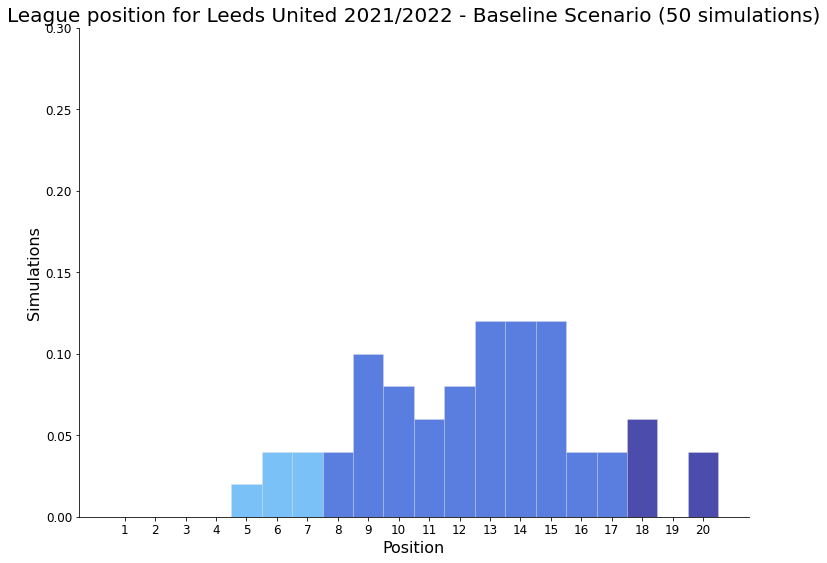

10.0% probability of top 7 (European qualification)
10.0% probability of relegation
20.0% probability of just above relegation


In [27]:
# Baseline scenario
positions_2021 = list()

num_simulations = 50  # Decreased for faster run time

for i in tqdm(range(num_simulations)):
    position = simulateSeasonXG(model=poisson_model_log, model_type='xG + log(MV)', year=2021, scenario=None)
    positions_2021.append(position)

plot_results(positions_2021, "2021/2022 - Baseline Scenario")

100%|██████████| 50/50 [03:52<00:00,  4.66s/it]


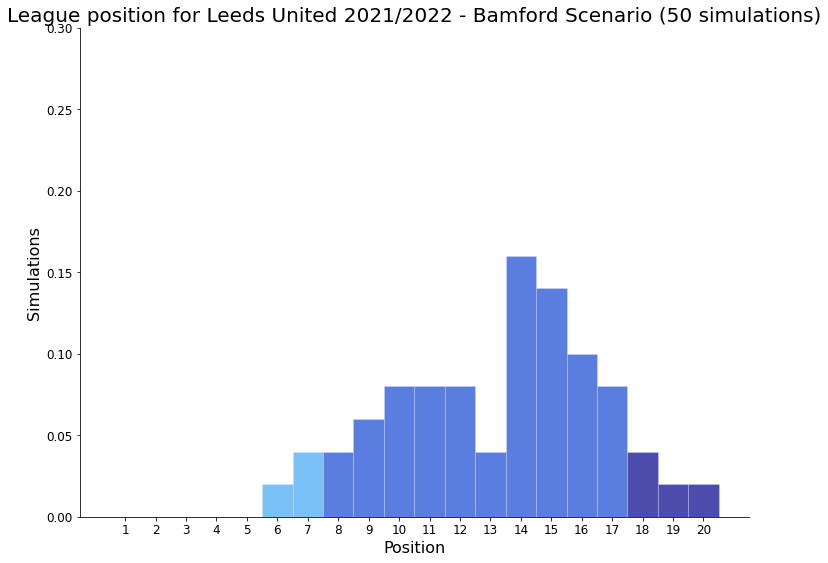

6.0% probability of top 7 (European qualification)
8.0% probability of relegation
32.0% probability of just above relegation


In [30]:
# Scenario: Bamford gets injured
positions_2021 = list()

num_simulations = 50  # Decreased for faster run time

for i in tqdm(range(num_simulations)):
    position = simulateSeasonXG(model=poisson_model_log, model_type='xG + log(MV)', year=2021, scenario='bamford')
    positions_2021.append(position)

plot_results(positions_2021, "2021/2022 - Bamford Scenario")

100%|██████████| 50/50 [03:49<00:00,  4.58s/it]


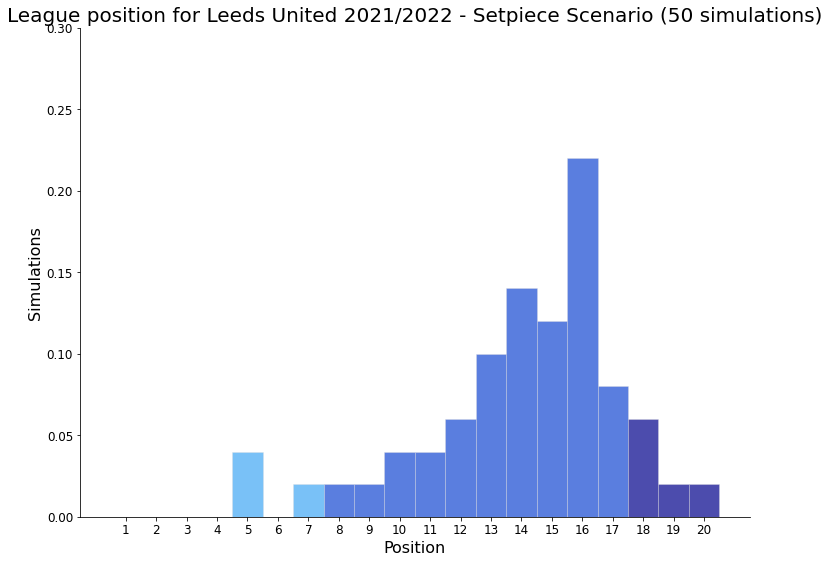

6.0% probability of top 7 (European qualification)
10.0% probability of relegation
42.0% probability of just above relegation


In [32]:
# Scenario: Leeds improve their defensive set pieces.
positions_2021 = list()

num_simulations = 50  # Decreased for faster run time

for i in tqdm(range(num_simulations)):
    position = simulateSeasonXG(model=poisson_model_log, model_type='xG + log(MV)', year=2021, scenario='setpiece')
    positions_2021.append(position)

plot_results(positions_2021, "2021/2022 - Setpiece Scenario")

### Include Form 
The season will be simulated in 38 gameweeks of 10 fixtures. Form constitutes a team's previous 6 results, a team with perfect form increases their goal scoring rate by 10% and with the worst possible form their rate decreases by 10%. The team's point tally from the previous 6 games is linearly transformed into a % between -10% to 10%.

In [33]:
def matches_played(team, standings):
    """Return number of matches played by team"""
    return standings.at[team, 'W'] + standings.at[team, 'D'] + standings.at[team, 'L']

def get_form(matches):
    """
    Return linear transformation of point tally from previous 6 matches. Range: [0.9, 1.1]
    """
    result_values = {"W": 3, "D": 1, "L": 0}
    return (sum(result_values[result] for result in matches) / 18) * 0.2 + 0.9

In [34]:
def generate_fixtures(teams):
    """
    Returns a round-robin scheduling of a 38 gameweek season consisting of 20 teams
            
        Parameters:
            teams (list): A list of 20 teams
            
        Returns: 
            fixtures (list): A list of 38 lists (gameweeks) of 10 tuples (matches)
            
    """
    n = len(teams)
    matches = []
    fixtures = []
    return_matches = []
    for fixture in range(1, n):
        for i in range(int(n/2)):
            matches.append((teams[i], teams[n - 1 - i]))
            return_matches.append((teams[n - 1 - i], teams[i]))
        teams.insert(1, teams.pop())
        fixtures.insert(int(len(fixtures)/2), matches)
        fixtures.append(return_matches)
        matches = []
        return_matches = []
        
    return fixtures


# Final model

In [62]:
def simulateMatchForm(model, home_team, away_team, standings, year, scenario, form=False):
    home_form, away_form = 1, 1
    
    # update form and remove expired result if team has played 6+ matches
    if matches_played(home_team, standings) > 5 and matches_played(away_team, standings) > 5:
        home_form = get_form(standings.at[home_team, 'Form'])
        away_form = get_form(standings.at[away_team, 'Form'])
        standings.at[home_team, 'Form'].pop(0)
        standings.at[away_team, 'Form'].pop(0)
    elif matches_played(home_team, standings) > 5:
        home_form = get_form(standings.at[home_team, 'Form'])
        standings.at[home_team, 'Form'].pop(0)
    elif matches_played(away_team, standings) > 5:
        away_form = get_form(standings.at[away_team, 'Form'])
        standings.at[away_team, 'Form'].pop(0)
        
    # include form in scoring rates
    if form:
        home_score_rate = home_form * model.predict(pd.DataFrame(data={'team_xG': get_xG(home_team, True, year, scenario=scenario), 
                                                           'opponent_xGC': get_xGC(away_team, False, year, scenario=scenario), 
                                                           'team_value': get_market_value(home_team, year, normalization='log'), 
                                                           'opponent_value': get_market_value(away_team, year, normalization='log')},
                                                     index=[1]))
        away_score_rate = away_form * model.predict(pd.DataFrame(data={'team_xG': get_xG(away_team, False, year, scenario),
                                                                               'opponent_xGC': get_xGC(home_team, True, year, scenario),
                                                                               'team_value': get_market_value(away_team, year, normalization='log'),
                                                                               'opponent_value': get_market_value(home_team, year, normalization='log')},index=[1]))
    else:
        home_score_rate = model.predict(pd.DataFrame(data={'team_xG': get_xG(away_team, False, year, scenario=scenario),
                                                           'opponent_xGC': get_xGC(home_team, True, year, scenario=scenario),
                                                           'team_value': get_market_value(away_team, year, normalization='log'),
                                                           'opponent_value': get_market_value(home_team, year, normalization='log')},
                                                     index=[1]))
        away_score_rate = model.predict(pd.DataFrame(data={'team_xG': get_xG(away_team, False, year, scenario=scenario),
                                                           'opponent_xGC': get_xGC(home_team, True, year, scenario=scenario),
                                                           'team_value': get_market_value(away_team, year, normalization='log'),
                                                           'opponent_value': get_market_value(home_team, year, normalization='log')},
                                                     index=[1]))


    # Simulate results
    home_goals = np.random.poisson(home_score_rate)[0]
    away_goals = np.random.poisson(away_score_rate)[0]
    
    # Assign results to standings
    if home_goals > away_goals:
        standings.at[home_team, 'W'] += 1
        standings.at[away_team, 'L'] += 1
        standings.at[home_team, 'Form'].append('W')
        standings.at[away_team, 'Form'].append('L')
    elif home_goals < away_goals:
        standings.at[home_team, 'L'] += 1
        standings.at[away_team, 'W'] += 1
        standings.at[home_team, 'Form'].append('L')
        standings.at[away_team, 'Form'].append('W')
    else:
        standings.at[home_team, 'D'] += 1
        standings.at[away_team, 'D'] += 1
        standings.at[home_team, 'Form'].append('D')
        standings.at[away_team, 'Form'].append('D')

    standings.at[home_team, 'GF'] += home_goals
    standings.at[home_team, 'GA'] += away_goals

    standings.at[away_team, 'GF'] += away_goals
    standings.at[away_team, 'GA'] += home_goals
    
    return home_team, home_goals, away_team, away_goals

In [60]:
def simulateSeasonForm(model, year, sample_promoted=True, return_table=False, scenario=None, form=False, return_pred_results=False):
    """
    Simulate a 38 gameweek season consisting of 20 teams
            
        Parameters:
            model (Poisson GLM): Fitted on previous season(s) data.
            year (int): Year of season that we want to predict.
            sample_promoted (Boolean): Take a sample of promoted team's statistics from three previous seasons.
            scenario (Boolean): Adjust Leed's statitics based on a hypothetical scenario.
            form (Boolean): Adjust scoring rates for individual matches (-10%, +10%) based on form.
            
        Returns: 
            (int): Position of Leed's upon season completion.
            
    """
    if year == 2020:
        teams = df_us_2020.home_team.unique()
    elif year == 2021:
        teams = df_us_2021.home_team.unique()
      
    if sample_promoted:
        promoted_teams = ["Brentford","Norwich","Watford"] if year == 2021 else ["Fulham","West Bromwich Albion","Leeds"]
        for team in promoted_teams:
            sample = np.random.choice(list(promoted_xg.keys()),size=1, replace=False)[0]

            # Assign a sampled xG & xGC to the promoted teams.
            if year == 2020:
                if team in df_xg_2019.team.values:
                    df_xg_2019.loc[df_xg_2019.team == team, ['xG_home','xG_away','xGC_home','xGC_away']] = promoted_xg[sample]
                else:
                    df_xg_2019.loc[len(df_xg_2019.index)] = [team] + [x for x in promoted_xg[sample]]
                    
            if year == 2021:
                if team in df_xg_2020.team.values:
                    df_xg_2020.loc[df_xg_2020.team == team, ['xG_home','xG_away','xGC_home','xGC_away']] = promoted_xg[sample]
                else:
                    df_xg_2020.loc[len(df_xg_2020.index)] = [team] + [x for x in promoted_xg[sample]]

    
    # Store outcome of results in a dict to create the table later on
    standings = dict()

    results = {
        'W': 0,
        'D': 0,
        'L': 0,
        'GF': 0,
        'GA': 0, 
        'Form':[]
    }
    
    for team in teams:
        team_results = results.copy()
        team_results['Form'] = []
        standings[team] = team_results

    standings = pd.DataFrame.from_dict(standings, orient='index')
    match_predictions = [0,0,0,0]
    
    teams = teams.tolist()
    random.shuffle(teams)
    fixtures = generate_fixtures(teams)
    
    for gameweek in fixtures:
        for match in gameweek:
            home_team, home_goals, away_team, away_goals = simulateMatchForm(model, match[0], match[1],\
                                                                             standings, year, scenario, form)
            result_365 = simulateMatchBet365(match[0], match[1], year)
            result_true = getTrueResults(match[0], match[1], year)
            result_sim = ''
            if home_goals > away_goals:
                result_sim = '1'
            elif home_goals < away_goals:
                result_sim = 'X'
            else:
                result_sim = '2'
            
            match_predictions[0] += 1 * (result_sim == result_true)
            match_predictions[1] += 1 * (result_sim != result_true)
            match_predictions[2] += 1 * (result_365 == result_true)
            match_predictions[3] += 1 * (result_365 != result_true)
            
            
    standings['M'] = standings.W + standings.D + standings.L # Matches
    standings['GD'] = standings.GF - standings.GA  # Goal difference
    standings['P'] = 3 * standings.W + 1 * standings.D  # Points

    table = standings.sort_values(by=['P', 'GD'], ascending=False).rename_axis('Team').reset_index()
    table.index = np.arange(1, len(table) + 1)
    
    if return_table:
        return table
    else:
        if not return_pred_results:
            return table.loc[table.Team == 'Leeds'].index[0]  # return Leeds placement in the league.
        else:
            return table.loc[table.Team == 'Leeds'].index[0], match_predictions  # return placement and prediction results

100%|██████████| 500/500 [39:05<00:00,  4.69s/it]


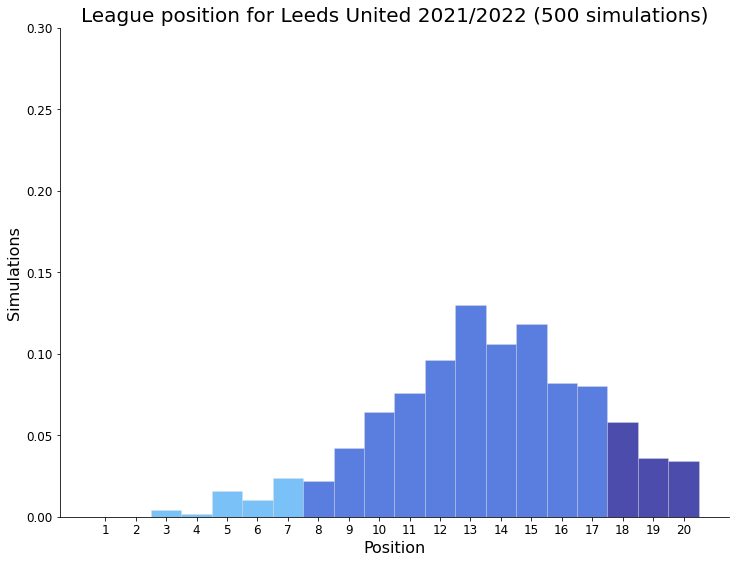

5.6% probability of top 7 (European qualification)
12.8% probability of relegation
28.0% probability of just above relegation


In [63]:
positions_2021_form = list()

num_simulations = 500  # Decreased for faster run time

for i in tqdm(range(num_simulations)):
    position = simulateSeasonForm(model=poisson_model_log, year=2021, form=True)
    positions_2021_form.append(position)
    
plot_results(positions_2021_form, "2021/2022")

100%|██████████| 200/200 [17:41<00:00,  5.31s/it]


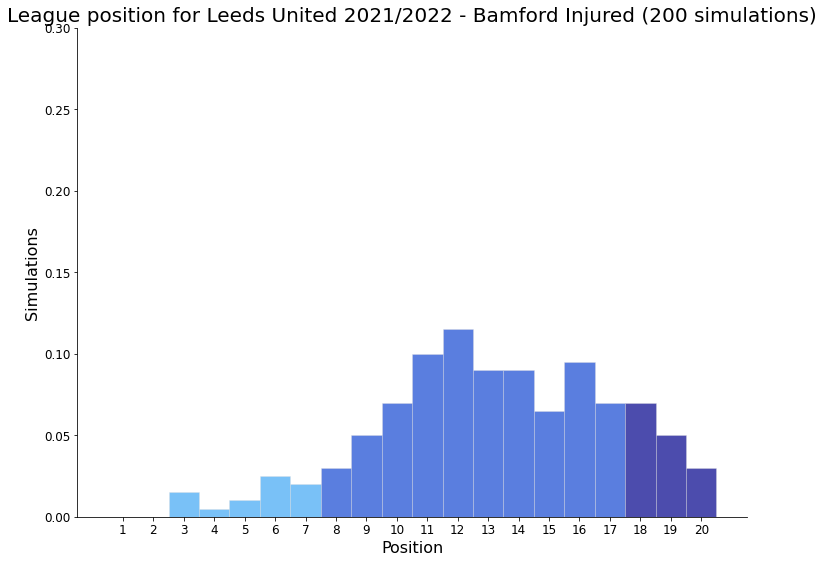

7.5% probability of top 7 (European qualification)
15.0% probability of relegation
23.0% probability of just above relegation


In [65]:
positions_2021_form_bamford = list()

num_simulations = 200  # Decreased for faster run time

for i in tqdm(range(num_simulations)):
    position = simulateSeasonForm(model=poisson_model_log, year=2021, form=True, scenario='bamford')
    positions_2021_form_bamford.append(position)
    
plot_results(positions_2021_form_bamford, "2021/2022 - Bamford Injured")

100%|██████████| 200/200 [17:30<00:00,  5.25s/it]


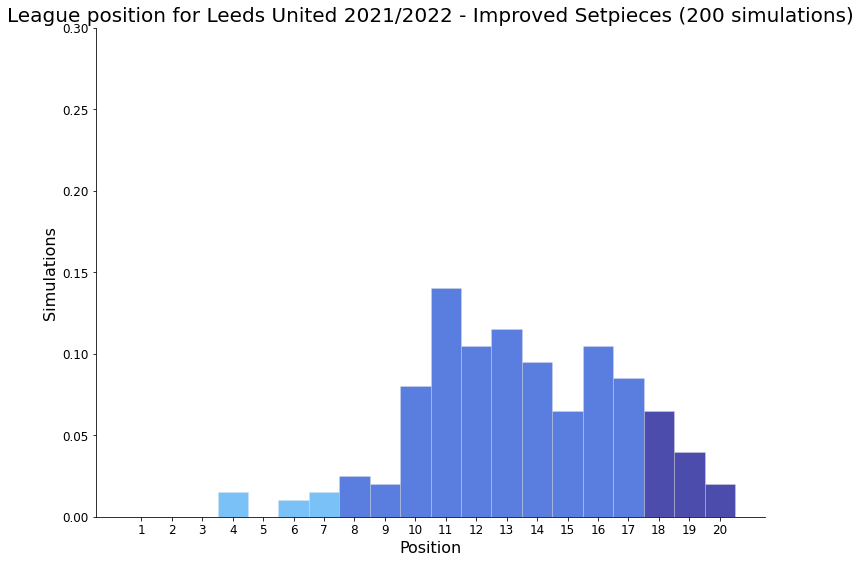

4.0% probability of top 7 (European qualification)
12.5% probability of relegation
25.5% probability of just above relegation


In [66]:
positions_2021_form_def = list()

num_simulations = 200  # Decreased for faster run time

for i in tqdm(range(num_simulations)):
    position = simulateSeasonForm(model=poisson_model_log, year=2021, form=True, scenario='setpiece')
    positions_2021_form_def.append(position)
    
plot_results(positions_2021_form_def, "2021/2022 - Improved Setpieces")